# Lab 3: Plasticity and learning

In this lab, we will from static circuit to dynamics circuit where the connectivity will change following plasticity rules in un-supervised way or reward-dependent way. 

(Code by Lihao Guo, Questions by Arvind Kumar 2022. The tutorial is inspired by the Neuronal Dynamics book from Wulfram Gerstner, Werner M. Kistler, Richard Naud and Liam Paninski. https://neuronaldynamics.epfl.ch/online/index.html.)

In [ ]:
#@title Run the following to initialize lab environment.
debug = 'google.colab' not in str(get_ipython())
if not debug:
    import os, sys

    # clone respository
    user = "michaelglh"
    repo = "STG"
    if os.path.isdir(repo):
        !rm -rf {repo}
    !git clone https://github.com/{user}/{repo}.git

    # add path to system
    src_dir = ""
    path = f"{repo}/{src_dir}"
    if not path in sys.path:
        sys.path.insert(1, path)

    from google.colab import output
    output.enable_custom_widget_manager()

    !pip install ipympl==0.8.0 --quiet

    import matplotlib.backends

In [1]:
#@title Run the following to download necessary files.
from lib.neuron import LIF
from lib.input import Poisson_generator, Gaussian_generator, Current_injector
from lib.conn import Simulator
from lib.helper import plot_volt_trace, pair_volt_trace
    
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats                      
import ipywidgets as widgets            # interactive display
my_layout = widgets.Layout()

# setting for figures
fig_w, fig_h = 8, 6
my_fontsize = 18
my_params = {'axes.labelsize': my_fontsize,
          'axes.titlesize': my_fontsize,
          'figure.figsize': (fig_w, fig_h),
          'font.size': my_fontsize,
          'legend.fontsize': my_fontsize-4,
          'lines.markersize': 8.,
          'lines.linewidth': 2.,
          'xtick.labelsize': my_fontsize-2,
          'ytick.labelsize': my_fontsize-2}

plt.rcParams.update(my_params)

# Auto Reloading
%load_ext autoreload
%autoreload 2
%matplotlib widget

### Different types of synaptic plasticities
* Two-factor plasticity
* Spike-timeing-dependent long-term plasticity

interactive(children=(Dropdown(description='c_ts', options=('Static', 'Hebb', 'STDP'), value='Static'), FloatS…

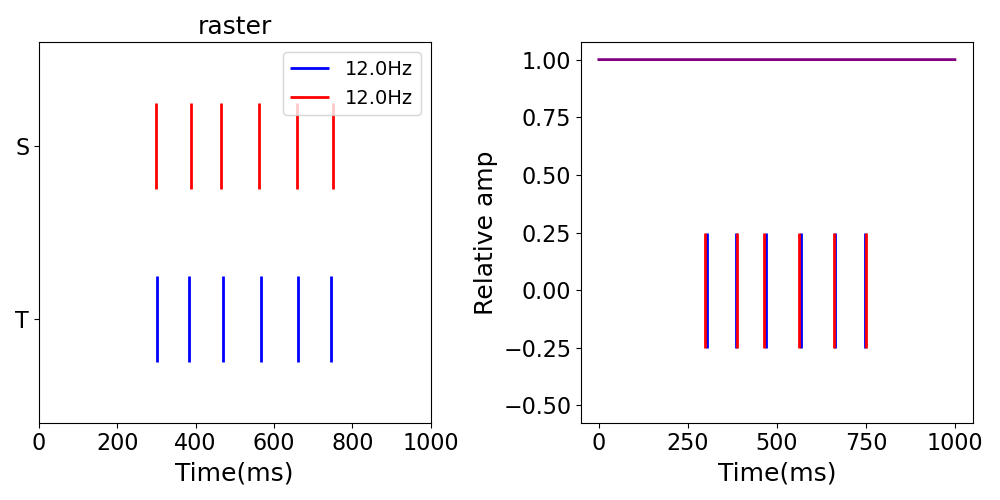

In [2]:
#@title Run the following to start hebbain plasticity simulation { vertical-output: true }
T, dt = 1e3, 0.1        # simulation period(ms), step size(ms)
N = 2                  # number of neurons

# neuron types
tonic_neuron = {'tau_m':20., 'a':0., 'tau_w':30., 'b':3., 'V_reset':-55.}
adapting_neuron = {'tau_m':20., 'a':0., 'tau_w':100., 'b':0.5, 'V_reset':-55.}
initburst_neuron = {'tau_m':10., 'a':0., 'tau_w':100., 'b':1., 'V_reset':-50.}
bursting_neuron = {'tau_m':5., 'a':0., 'tau_w':100., 'b':1., 'V_reset':-46.}
irregular_neuron = {'tau_m':10., 'a':-0.01, 'tau_w':50., 'b':1.2, 'V_reset':-46.}
transient_neuron = {'tau_m':5., 'a':0.05, 'tau_w':100., 'b':0.7, 'V_reset':-60.}
delayed_neuron = {'tau_m':5., 'a':-0.1, 'tau_w':100., 'b':1., 'V_reset':-60.}
rebound_neuron = {'tau_m':5., 'a':0.2, 'tau_w':150., 'b':0.1, 'V_reset':-54.}

neuron_params = {'tonic_neuron': tonic_neuron, 'adapting_neuron': adapting_neuron, 
                 'initburst_neuron': initburst_neuron, 'bursting_neuron': bursting_neuron, 
                 'irregular_neuron': irregular_neuron, 'transient_neuron': transient_neuron, 
                 'delayed_neuron': delayed_neuron, 'rebound_neuron': rebound_neuron}
    
# input types
Itypes = ['Gaussian', 'Poisson']

# connection types
Ctypes = ['Static', 'Hebb', 'STDP']

# updating parameters
def update_pls(c_ts='Static', J_ts=1.0, rt=50., rs=50., Itype='Icur'):
    # simualtor
    h = Simulator(dt=dt)

    # network of neurons
    nrns = [LIF(sim=h) for _ in range(N)]
    for nrn in nrns:
        nrn.update(tonic_neuron)

    # background noise
    if Itype == 'Gaussian':
        noises = [Gaussian_generator(sim=h, mean=r, std=r, start=int(T/dt*0.25), end=int(T/dt*0.75)) for r in [rt, rs]]
    elif Itype == 'Poisson':
        noises = [Poisson_generator(sim=h, rate=r*3, start=int(T/dt*0.25), end=int(T/dt*0.75)) for r in [rt, rs]]
    else:
        print('Invalid input')
    for noise, nrn in zip(noises, nrns):
        nrn.connect(noise, {'ctype':'Static', 'weight':1e0, 'delay':5})      

    # recurrent connections
    tps = [['Static' for _ in range(N)] for _ in range(N)]
    tps[0][1] = c_ts
    con = np.array([[0., J_ts],
                    [0., 0.]])
    dly = np.random.uniform(2., 5., (N,N))
    synspecs = [[{} for _ in range(N)] for _ in range(N)]
    for i in range(N):
        for j in range(N):
            synspecs[i][j] = {'ctype':tps[i][j], 'weight':con[i,j], 'delay':dly[i,j]}
    cons = h.connect(nrns, nrns, synspecs)

    # simulation
    h.run(T)

    # visualize
    plt.clf()
    cs = ['b', 'r']
    plt.subplot(1,2,1)
    plt.title('raster')
    for nrn, c, l in zip(nrns, cs, range(N)):
        plt.eventplot(nrn.spikes['times'], lineoffsets=2*l, colors=c, label='%.1fHz'%(len(nrn.spikes['times'])/T*1e3*2))
    plt.xlabel('Time(ms)')
    plt.yticks(list(np.arange(N)*2), ['T', 'S'])
    plt.xlim([0., T])
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.arange(0., T, dt), cons[0][1].weights, c='purple')
    for nrn, c in zip(nrns, cs):
        plt.eventplot(nrn.spikes['times'], lineoffsets=0, linelengths=0.5, colors=c)
    plt.xlabel('Time(ms)')
    plt.ylabel('Relative amp')
    plt.tight_layout()

fig_pls, axes = plt.subplots(1,2,figsize=(10,5))
widgets.interact(update_pls, c_ts=Ctypes, J_ts=(0.01, 2., 0.01), rt=(0., 100., 10.), rs=(0., 100., 10.), Itype=Itypes);

### Learning

* Unsupervised competitive learning (rate model)
* Reward-based learning (spiking model)

interactive(children=(FloatSlider(value=0.5, description='mean', max=1.0, step=0.01), FloatSlider(value=0.1, d…

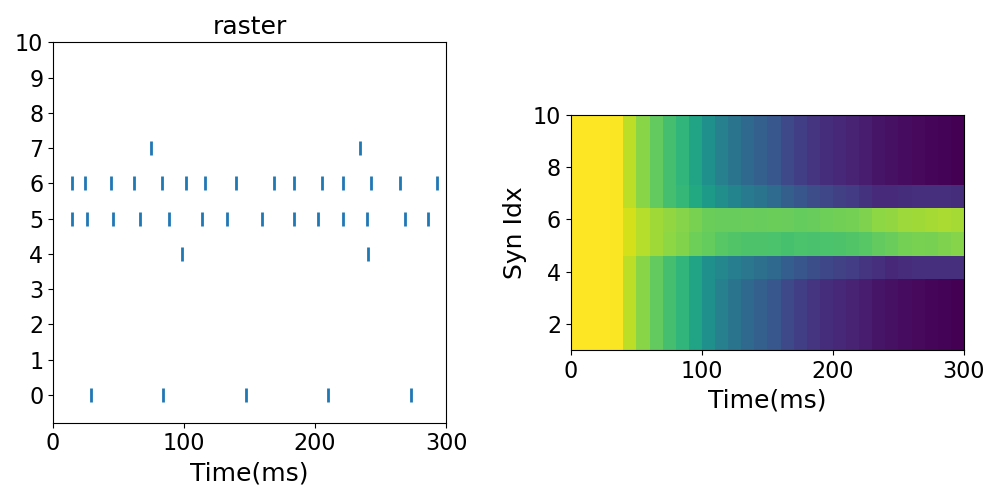

In [30]:
#@title Run the following to start competitive learning { vertical-output: true }
T, dt = 3e2, 0.1        # simulation period(ms), step size(ms)
N = 11                  # number of neurons

# neuron types
tonic_neuron = {'tau_m':20., 'a':0., 'tau_w':30., 'b':3., 'V_reset':-55.}
adapting_neuron = {'tau_m':20., 'a':0., 'tau_w':100., 'b':0.5, 'V_reset':-55.}
initburst_neuron = {'tau_m':10., 'a':0., 'tau_w':100., 'b':1., 'V_reset':-50.}
bursting_neuron = {'tau_m':5., 'a':0., 'tau_w':100., 'b':1., 'V_reset':-46.}
irregular_neuron = {'tau_m':10., 'a':-0.01, 'tau_w':50., 'b':1.2, 'V_reset':-46.}
transient_neuron = {'tau_m':5., 'a':0.05, 'tau_w':100., 'b':0.7, 'V_reset':-60.}
delayed_neuron = {'tau_m':5., 'a':-0.1, 'tau_w':100., 'b':1., 'V_reset':-60.}
rebound_neuron = {'tau_m':5., 'a':0.2, 'tau_w':150., 'b':0.1, 'V_reset':-54.}

neuron_params = {'tonic_neuron': tonic_neuron, 'adapting_neuron': adapting_neuron, 
                 'initburst_neuron': initburst_neuron, 'bursting_neuron': bursting_neuron, 
                 'irregular_neuron': irregular_neuron, 'transient_neuron': transient_neuron, 
                 'delayed_neuron': delayed_neuron, 'rebound_neuron': rebound_neuron}
    
# input types
Itypes = ['Gaussian', 'Poisson']

# updating parameters
def update_comp(mean=0.5, std=0.1,  Itype='Icur'):
    # simualtor
    h = Simulator(dt=dt)

    # network of neurons
    nrns = [LIF(sim=h) for _ in range(N)]
    for nrn in nrns:
        nrn.update(tonic_neuron)

    # background noise
    rs = [50.0] + [scipy.stats.norm(mean, std).pdf(x)*4e1 for x in np.linspace(0., 1.0, N-1)]
    if Itype == 'Gaussian':
        noises = [Gaussian_generator(sim=h, mean=r, std=r, start=0, end=int(T/dt)) for r in rs]
    elif Itype == 'Poisson':
        noises = [Poisson_generator(sim=h, rate=r*3, start=0, end=int(T/dt)) for r in rs]
    else:
        print('Invalid input')
    for noise, nrn in zip(noises, nrns):
        nrn.connect(noise, {'ctype':'Static', 'weight':1e0, 'delay':5})      

    # recurrent connections
    tps = [['Static' for _ in range(N)] for _ in range(N)]
    for i in np.arange(1, N):
        tps[0][i] = 'Comp'
    con = np.zeros((N,N))
    con[0, 1:] = 0.5
    dly = np.random.uniform(2., 5., (N,N))
    synspecs = [[{} for _ in range(N)] for _ in range(N)]
    for i in range(N):
        for j in range(N):
            synspecs[i][j] = {'ctype':tps[i][j], 'weight':con[i,j], 'delay':dly[i,j]}
    cons = h.connect(nrns, nrns, synspecs)

    # simulation
    h.run(T)

    # visualize
    plt.clf()
    plt.subplot(1,2,1)
    plt.title('raster')
    for nrn, l in zip(nrns, range(N)):
        plt.eventplot(nrn.spikes['times'], lineoffsets=l, linelengths=0.4, label='%.1fHz'%(len(nrn.spikes['times'])/T*1e3*2))
    plt.xlabel('Time(ms)')
    plt.yticks(list(np.arange(N)))
    plt.xlim([0., T])

    plt.subplot(1,2,2)
    weights = np.array([cons[0][i].weights for i in np.arange(1, N)])
    plt.imshow(weights[:, np.arange(0, int(T/dt), 100)], extent=[0, T, 1, 10], origin='lower', aspect=20)
    plt.xlabel('Time(ms)')
    plt.ylabel('Syn Idx')
    plt.tight_layout()

fig_comp, axes = plt.subplots(1,2,figsize=(10,5))
widgets.interact(update_comp, mean=(0., 1.0, 0.01), std=(0.1, 0.5, 0.1), Itype=Itypes);